In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from matplotlib import pyplot as plt

torch.manual_seed(1806)
np.set_printoptions(precision=3)

# MC-LSTM: a Demo

This is a simple demo to illustrate how Mass-Conserving LSTMs (MC-LSTMs) can be used.

### LSTM Addition Problem

The mass conservation in MC-LSTM is of especially useful for regression problems.
Therefore, one of the tasks in the paper is the LSTM addition problem.
The data consists of a sequence of inputs and a sequence of markers,
and the goal is to predict the sum of marked inputs.
This is one of the easiest examples of a problem
where the *mass* of the inputs must be conserved.

In [2]:
from experiments.addition.data import Addition
data = Addition(1000, seq_len=10, max_mass=.5)
loader = DataLoader(data, batch_size=32)
xm, xa, y = data[0]

print("example sample")
print("x:", xm.squeeze())
print("a:", xa.squeeze())
print("y:", y.squeeze(), "=", f"sum({xm[xa == 1]})")

example sample
x: [0.159 0.386 0.174 0.274 0.424 0.323 0.206 0.165 0.234 0.199]
a: [ 0.  0.  0.  1.  1.  0.  0.  0.  0. -1.]
y: 0.6979072 = sum([0.274 0.424])


### MC-LSTM Usage

For a regular LSTM, the sequence of inputs and markers would be concatenated into a single sequence.
The MC-LSTM distinguishes between *mass* inputs, which represent the quantity to be conserved,
and *auxiliary* inputs, which contain other information.
Therefore, the construction of the MC-LSTM requires separate mass and auxiliary input dimensions.

In this example, we use a MC-LSTM with two cells to optimise the MSE with SGD.
We also make use of the default, time-independent gating mechanism,
but remember that it is possible to make the gates arbitrarily complex hyper-networks.

In [3]:
from mclstm import MassConservingLSTM
mc_lstm = MassConservingLSTM(1, 1, 2, time_dependent=False, batch_first=True)
mc_lstm.reset_parameters()  # initialisation
sgd = torch.optim.SGD(mc_lstm.parameters(), lr=5e-2, momentum=0.99)
mse = torch.nn.MSELoss()

Note that the distinction between mass and auxiliary inputs is also implemented in the dataloader.
Apart from these minor modifications, the MC-LSTM can be trained as a regular LSTM.

In [4]:
def update(samples, model, loss, opt):
    err_sum = 0
    for xm, xa, y in samples:
        m_out, c = model(xm, xa)
        y_hat = m_out[:, -1:].sum(dim=-1)
        err = loss(y_hat, y)
        err_sum += err.item()

        opt.zero_grad()
        err.backward()
        opt.step()

    return err_sum / len(loader)

@torch.no_grad()
def evaluate(samples, model, loss):
    err_sum = 0
    for xm, xa, y in samples:
        m_out, c = model(xm, xa)
        y_hat = m_out[:, -1:].sum(dim=-1)
        err = loss(y_hat, y)
        err_sum += err.item()

    return err_sum / len(loader)

0.00016922203553804138

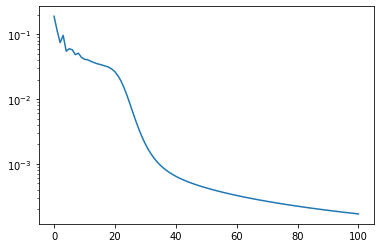

In [5]:
errs = [evaluate(loader, mc_lstm, mse)]
errs += [update(loader, mc_lstm, mse, sgd) for _ in trange(100)]
plt.semilogy(errs)
errs[-1]

### MC-LSTM Generalisation

Note that the MC-LSTM could be trained longer to reduce the error even further.
However, the evaluation below indicates that it already found a general solution.
Whereas the training data contained sequences of length 10 with 2 marked numbers between 0 and 0.5,
the test sequence below illustrates that the learned solution generalises quite well.

In [6]:
test = Addition(1, seq_len=20, max_components=5, max_mass=3., seed=1806)
test_loader = DataLoader(test)
(xm, xa, y), = iter(test_loader)
with torch.no_grad():
    m_out, c = mc_lstm(xm, xa)
print("x:", xm.squeeze().view(4, 5))
print("a:", xa.squeeze().view(4, 5))
print("y:", y.squeeze())
print("pred:", m_out[:, -1].sum(-1).item())

x: tensor([[1.3770, 1.4060, 2.7712, 2.7821, 1.6196],
        [2.7172, 1.8553, 2.3128, 2.4772, 2.2771],
        [2.6702, 1.4422, 2.7337, 1.2465, 0.0204],
        [2.2263, 0.6764, 0.9901, 1.9084, 1.4018]])
a: tensor([[ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  1.,  0.,  0., -1.]])
y: tensor(3.4788)
pred: 3.577552318572998


Moreover, if we look at the behaviour of the two cell states in the MC-LSTM,
we find the behaviour that we would expect:
one cell is incremented every time an input is marked by an amount that corresponds to the input value,
whereas the other cell accumulates the other values and dumps them every now and then.
In the final timestep, the accumulating cell is emptied to provide the prediction.

Text(0, 0.5, 'cell state value')

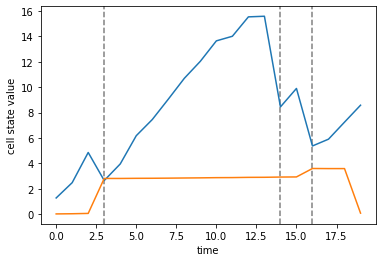

In [7]:
_, idx, _ = np.where(xa == 1)
for i in idx:
    plt.axvline(i, color='grey', linestyle='--')
plt.plot(c[0])
plt.xlabel('time')
plt.ylabel('cell state value')